# Benchmarking

In [ ]:
from Utility import generate_matrix,generate_qram_circuit,generate_phase_estimation_circuit,eigenvectors_benchmarking,eigenvectors_reconstruction,state_vector_tomography,thetas_computation

# Matrix generation

In [13]:
eigenvalues=[2,1]
input_matrix=generate_matrix(matrix_dimension=2,eigenvalues_list=eigenvalues,replicate_paper=False)

Matrix:
 [[ 1.68 -0.47]
 [-0.47  1.32]]

eigenvalue: 1 - eigenvector: [0.565 0.825]
eigenvalue: 2 - eigenvector: [ 0.825 -0.565]


# Create circuit for matrix encoding 

In [14]:
thetas, all_combinations = thetas_computation(input_matrix)
matrix_circuit = generate_qram_circuit(input_matrix,thetas, all_combinations)
matrix_circuit.draw()

┌────────────┐┌───┐               ┌───┐              
q_0: ┤ Ry(1.3527) ├┤ X ├───────■───────┤ X ├──────■───────
     └────────────┘└───┘┌──────┴──────┐└───┘┌─────┴──────┐
q_1: ───────────────────┤ Ry(0.54147) ├─────┤ Ry(2.4622) ├
                        └─────────────┘     └────────────┘

# Perform Phase estimation and tomography 

In [15]:
pe_circuit=generate_phase_estimation_circuit(resolution=2,input_matrix=input_matrix)

In [16]:
statevector_dictionary=state_vector_tomography(matrix_circuit=matrix_circuit,pe=pe_circuit,n_shots=50000)

/opt/miniconda3/envs/EAGLE_environment/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/miniconda3/envs/EAGLE_environment/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


# Reconstruct eigenvectors

In [17]:
eigenvectors=eigenvectors_reconstruction(statevector_dictionary=statevector_dictionary,resolution=2,input_matrix=input_matrix)

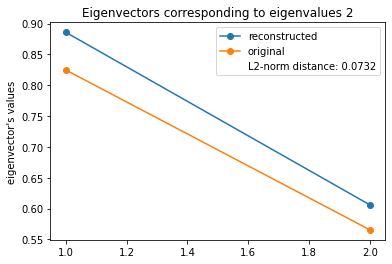

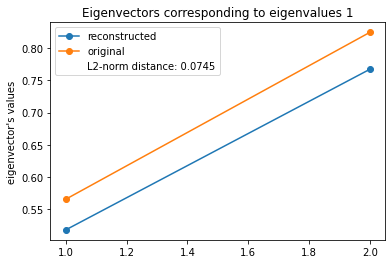

In [18]:
eigenvectors_benchmarking(originals=input_matrix,reconstructed_eigenvectors=eigenvectors)